# Following keypoints tutorial of keras

Rather retinanet

In [1]:
# %pip install --upgrade keras-hub tensorflow-datasets

In [2]:
import os
import keras
import keras_hub
import numpy as np
import tensorflow_datasets as tfds

2025-01-12 00:43:55.756923: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-12 00:43:55.789582: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736639035.824513  555972 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736639035.834726  555972 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-12 00:43:55.871984: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
from FrameLoader import FrameLoader
from DataRepository import DataRepository
from DataGeneratorFrames import DataGeneratorFrames
from helpers import plot

In [22]:
repo = DataRepository()
frameloader = FrameLoader(repo)
datagen = DataGeneratorFrames(
    frameloader=frameloader,
    train_test_val="test",
    dim=(1024,1024),
    batch_size=1
)
object_detector = keras_hub.models.ImageObjectDetector.from_preset(
    "retinanet_resnet50_fpn_coco"
)

connection established, loading frame paths
rel paths of framelabels loaded
connection established, loading frame paths
rel paths of framelabels loaded
DataGeneratorSkillBorders init done


In [23]:
X_batch, y_batch = datagen.__getitem__(5)
img = datagen.__getitem__(5, normalize=False)[0]
X_batch.shape, img.shape

((1, 1024, 1024, 3), (1, 1024, 1024, 3))

In [24]:
prediction = object_detector(X_batch)

/home/miked/code/judge/computervision/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_213']
Received: inputs=Tensor(shape=(1, 1024, 1024, 3))
  warnings.warn(msg)


In [25]:
import numpy as np
import tensorflow as tf

# Step 1: Apply sigmoid to the class logits to get probabilities
class_probs = tf.nn.sigmoid(prediction['cls_logits'])

# Step 2: Get the class with the highest probability for each anchor
# Shape: (1, 9441)
class_ids = tf.argmax(class_probs, axis=-1)

# Step 3: Get the corresponding bbox regressions
# Shape: (1, 9441, 4)
bbox_reg = prediction['bbox_regression']

# Step 4: Decode the bounding boxes (applying the bounding box deltas to anchors)
# Here you would need the original anchor boxes to apply the deltas
# This requires knowing the anchors' base sizes and locations, which are typically
# pre-defined when building the RetinaNet model.

print(class_probs)



tf.Tensor(
[[[0.00177582 0.00595527 0.00248949 ... 0.00243026 0.00237184 0.00329972]
  [0.00183938 0.00438481 0.00198407 ... 0.00191627 0.00197113 0.0026482 ]
  [0.00198271 0.00450625 0.00137134 ... 0.00184069 0.00184027 0.0024309 ]
  ...
  [0.00395108 0.00656639 0.00402645 ... 0.00266282 0.00329258 0.00319699]
  [0.00418459 0.0044033  0.00351813 ... 0.00191749 0.00275898 0.00202437]
  [0.00438554 0.0066499  0.00384491 ... 0.00164364 0.00270184 0.00192928]]], shape=(1, 196416, 91), dtype=float32)


In [26]:
# Step 5: Apply confidence threshold
confidence_threshold = 0.70
confidences = tf.reduce_max(class_probs, axis=-1)  # Max confidence across all classes
high_confidence_mask = confidences > confidence_threshold

# Step 6: Filter the predictions
filtered_class_ids = class_ids[high_confidence_mask]
filtered_bboxes = bbox_reg[high_confidence_mask]
filtered_confidences = confidences[high_confidence_mask]

# Convert the bounding boxes from deltas to final coordinates (requires knowledge of anchor boxes)
# For simplicity, we assume the final bounding boxes are directly available as `filtered_bboxes`.

# Final bounding boxes and corresponding class IDs and confidences
final_boxes = filtered_bboxes.numpy()  # Apply further decoding to get real coordinates if needed
final_class_ids = filtered_class_ids.numpy()
final_confidences = filtered_confidences.numpy()

# You can now visualize or use these boxes for further processing


In [27]:
print(final_boxes)

[[ 0.00393424  0.17927074  0.15775202  0.16312777]
 [ 0.02123534  0.14808702 -0.06465463 -0.06575149]
 [ 0.02176783  0.04981873 -0.38214067  0.28426376]
 [ 0.02245858  0.04028283  0.16945189  0.16264516]
 [ 0.01749795  0.0327947  -0.06573799 -0.06497763]
 [-0.1368901   0.0522666  -0.3679443   0.28823256]
 [-0.18271592  0.03069217 -0.00894222 -0.06094614]
 [ 0.0217535  -0.11647823 -0.37100047  0.28561085]
 [ 0.02099765 -0.10248469  0.17465183  0.16129209]
 [ 0.01515586 -0.08282465 -0.0586672  -0.06339176]
 [-0.16708127 -0.07525507 -0.0039303  -0.07421581]
 [ 0.02937951 -0.23424882  0.15870327  0.1576826 ]
 [ 0.02600845 -0.19387384 -0.04423605 -0.06489754]]


In [28]:
final_class_ids

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [29]:
abs(final_boxes)

array([[0.00393424, 0.17927074, 0.15775202, 0.16312777],
       [0.02123534, 0.14808702, 0.06465463, 0.06575149],
       [0.02176783, 0.04981873, 0.38214067, 0.28426376],
       [0.02245858, 0.04028283, 0.16945189, 0.16264516],
       [0.01749795, 0.0327947 , 0.06573799, 0.06497763],
       [0.1368901 , 0.0522666 , 0.3679443 , 0.28823256],
       [0.18271592, 0.03069217, 0.00894222, 0.06094614],
       [0.0217535 , 0.11647823, 0.37100047, 0.28561085],
       [0.02099765, 0.10248469, 0.17465183, 0.16129209],
       [0.01515586, 0.08282465, 0.0586672 , 0.06339176],
       [0.16708127, 0.07525507, 0.0039303 , 0.07421581],
       [0.02937951, 0.23424882, 0.15870327, 0.1576826 ],
       [0.02600845, 0.19387384, 0.04423605, 0.06489754]], dtype=float32)

In [30]:
final_confidences

array([0.81680584, 0.8092539 , 0.73783875, 0.8309617 , 0.8269636 ,
       0.7120812 , 0.7900517 , 0.7211469 , 0.84577435, 0.8114988 ,
       0.72517514, 0.7095593 , 0.7839555 ], dtype=float32)

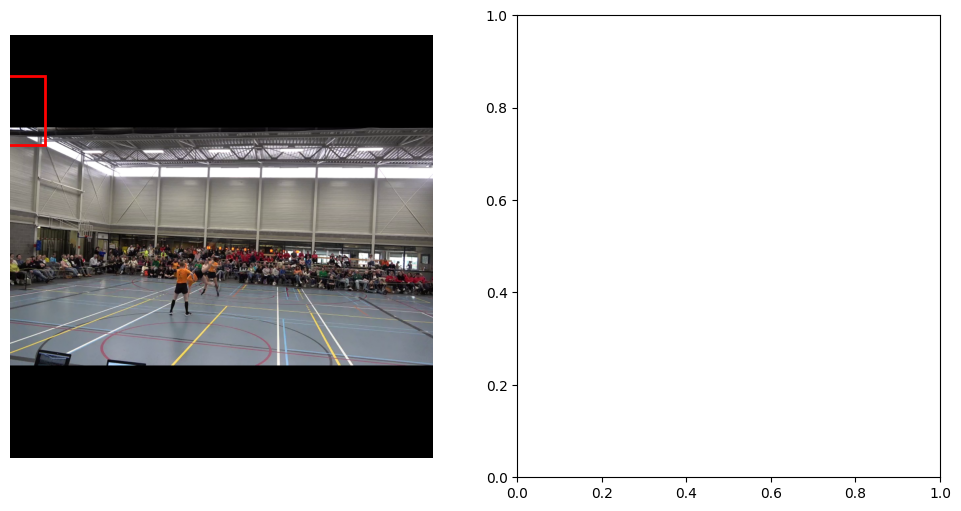

In [31]:
plot(img, bboxes=abs(final_boxes))

In [15]:
img.shape

(1, 1024, 1024, 3)